In [1]:
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from enum import Enum
from collections import namedtuple

class Movement(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Coordinate = namedtuple("Coordinate", "x, y")

# Инициализация Pygame
pygame.display.init()
pygame.font.init()

font = pygame.font.Font(pygame.font.get_default_font(), 25)

# RGB цвета
COLOR_WHITE = (255, 255, 255)
COLOR_RED = (200, 0, 0)
COLOR_GREEN = (0, 255, 0)
COLOR_LIGHT_GREEN = (153, 255, 153)
COLOR_BLACK = (0, 0, 0)

BLOCK_DIMENSION = 20
GAME_SPEED = 120

class SnakeGame:

    def __init__(self, width=640, height=480):
        self.width = width
        self.height = height

        # Инициализация дисплея
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Snake Game")
        self.clock = pygame.time.Clock()

        # Инициализация игры
        self.restart()

    def restart(self):
        self.direction = Movement.RIGHT
        self.head_position = Coordinate(self.width / 2, self.height / 2)
        self.snake_body = [self.head_position,
                           Coordinate(self.head_position.x - BLOCK_DIMENSION, self.head_position.y),
                           Coordinate(self.head_position.x - (2 * BLOCK_DIMENSION), self.head_position.y)]

        self.score = 0
        self.food_position = None

        self.spawn_food()

        self.frame_count = 0

    def spawn_food(self):
        x = random.randint(0, (self.width - BLOCK_DIMENSION) // BLOCK_DIMENSION) * BLOCK_DIMENSION
        y = random.randint(0, (self.height - BLOCK_DIMENSION) // BLOCK_DIMENSION) * BLOCK_DIMENSION
        self.food_position = Coordinate(x, y)
        if self.food_position in self.snake_body:
            self.spawn_food()

    def play_turn(self, action):
        # Увеличиваем количество кадров
        self.frame_count += 1

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    pygame.quit()
                    return

        # Перемещаем змею
        self.move_snake(action)

        reward = 0

        # Проверяем окончание игры
        if self.check_collision() or self.frame_count > 100 * len(self.snake_body):
            game_over = True
            reward -= 10
            return reward, game_over, self.score, self.frame_count

        # Перемещение змеи или размещение еды
        if self.head_position == self.food_position:
            self.score += 1
            reward = 10
            self.spawn_food()
        else:
            self.snake_body.pop()

        # Обновляем интерфейс и время
        self.update_display()
        self.clock.tick(GAME_SPEED)

        game_over = False

        return reward, game_over, self.score, self.frame_count

    def check_collision(self, point: Coordinate = None):
        if point is None:
            point = self.head_position

        # Проверка на столкновение со стенами
        if point.x > self.width - BLOCK_DIMENSION or point.x < 0:
            return True

        if point.y > self.height - BLOCK_DIMENSION or point.y < 0:
            return True

        # Проверка на столкновение с телом змеи
        if point in self.snake_body[1:]:
            return True

        return False

    def move_snake(self, action):
        # Определение направлений
        direction_sequence = [Movement.RIGHT, Movement.DOWN, Movement.LEFT, Movement.UP]
        current_index = direction_sequence.index(self.direction)

        new_direction = self.direction

        if np.array_equal(action, [0, 1, 0]):
            new_direction = direction_sequence[(current_index + 1) % 4]
        elif np.array_equal(action, [0, -1, 0]):
            new_direction = direction_sequence[(current_index - 1) % 4]

        self.direction = new_direction

        x = self.head_position.x
        y = self.head_position.y

        if self.direction == Movement.RIGHT:
            x += BLOCK_DIMENSION
        elif self.direction == Movement.LEFT:
            x -= BLOCK_DIMENSION
        elif self.direction == Movement.UP:
            y -= BLOCK_DIMENSION
        elif self.direction == Movement.DOWN:
            y += BLOCK_DIMENSION

        self.head_position = Coordinate(x, y)
        self.snake_body.insert(0, self.head_position)

    def update_display(self):
        self.display.fill(COLOR_BLACK)

        for p in self.snake_body:
            pygame.draw.rect(self.display, COLOR_GREEN, pygame.Rect(p.x, p.y, BLOCK_DIMENSION, BLOCK_DIMENSION))
            pygame.draw.rect(self.display, COLOR_LIGHT_GREEN, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, COLOR_RED, pygame.Rect(self.food_position.x, self.food_position.y, BLOCK_DIMENSION, BLOCK_DIMENSION))

        scoreText = font.render("Score: " + str(self.score) + " ; " + self.playerName + ' ; Q - выйти', True, COLOR_WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()


    def setPlayerName(self, name):
        self.playerName = name

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearQNet(nn.Module):

    def __init__(self, inputSize, hiddenSize, outputSize):
        super().__init__()

        self.linear1 = nn.Linear(inputSize, hiddenSize)
        self.linear2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, X):
        out = self.linear1(X)
        out = F.relu(out)
        out = self.linear2(out)

        return out

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

class QTrainner:

    def __init__(self, model, lr, gamma):
        self.model = model
        self.lr = lr
        self.gamma = gamma

        self.optimizer = optim.Adam(model.parameters(), self.lr)
        self.lossFunction = nn.MSELoss()

    def choose_random_action(self):
        return random.randint(0, self.action_space_size - 1)

    def trainStep(self, state, action, reward, newState, done):

        stateTensor = torch.tensor(state, dtype=torch.float)
        actionTensor = torch.tensor(action, dtype=torch.long)
        rewardTensor = torch.tensor(reward, dtype=torch.float)
        newStateTensor = torch.tensor(newState, dtype=torch.float)

        if len(stateTensor.shape) == 1:
            stateTensor = torch.unsqueeze(stateTensor, 0)
            newStateTensor = torch.unsqueeze(newStateTensor, 0)
            actionTensor = torch.unsqueeze(actionTensor, 0)
            rewardTensor = torch.unsqueeze(rewardTensor, 0)
            done = (done,)

        # 1. predicted q values with current state
        prediction = self.model(stateTensor)

        # Q_new = 2. reward + gamma * max(next predicted q value) -> only do this if not done
        target = prediction.clone()

        for i in range(len(done)):
            Qnew = rewardTensor[i]

            if not done[i]:
                Qnew = rewardTensor[i] + self.gamma * torch.max(self.model(newStateTensor[i]))

            target[i][torch.argmax(actionTensor).item()] = Qnew

        self.optimizer.zero_grad()
        loss = self.lossFunction(target, prediction)
        loss.backward()

        self.optimizer.step()


In [5]:
import torch
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    def __init__(self):
        self.numberOfGames = 0
        # controls randomness
        self.epsilon = 0
        # discount rate
        self.gamma = 1
        # the last actions, if we reach the limit we will remove the oldest
        self.memory = deque(maxlen=MAX_MEMORY)

        # the modelneeds to have 11 inputs, as our world status grid has 11 elements and the output is 3, as we have 3 directions
        self.model = LinearQNet(11, 256, 3)
        self.trainner = QTrainner(self.model, lr=LR, gamma=self.gamma)

    # this gives us the state of the world
    def getState(self, game):
        head = game.head_position

        point_left = Coordinate(head.x - BLOCK_DIMENSION, head.y)
        point_right = Coordinate(head.x + BLOCK_DIMENSION, head.y)
        point_up = Coordinate(head.x, head.y - BLOCK_DIMENSION)
        point_down = Coordinate(head.x, head.y + BLOCK_DIMENSION)

        direction_left = game.direction == Movement.LEFT
        direction_right = game.direction == Movement.RIGHT
        direction_up = game.direction == Movement.UP
        direction_down = game.direction == Movement.DOWN

        state = [
            # Danger straight
            (direction_right and game.check_collision(point_right)) or
            (direction_left and game.check_collision(point_left)) or
            (direction_up and game.check_collision(point_up)) or
            (direction_down and game.check_collision(point_down)),

            # Danger right
            (direction_up and game.check_collision(point_right)) or
            (direction_down and game.check_collision(point_left)) or
            (direction_left and game.check_collision(point_up)) or
            (direction_right and game.check_collision(point_down)),

            # Danger left
            (direction_down and game.check_collision(point_right)) or
            (direction_up and game.check_collision(point_left)) or
            (direction_right and game.check_collision(point_up)) or
            (direction_left and game.check_collision(point_down)),

            # Move direction
            direction_left,
            direction_right,
            direction_up,
            direction_down,

            # Food location
            game.food_position.x < game.head_position.x,  # food_position left
            game.food_position.x > game.head_position.x,  # food_position right
            game.food_position.y < game.head_position.y,  # food_position up
            game.food_position.y > game.head_position.y  # food_position down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def trainLongMemory(self):
        if len(self.memory) < BATCH_SIZE:
            sample = self.memory
        else:
            sample = random.sample(self.memory, BATCH_SIZE)

        states, actions, rewards, nextStates, dones = zip(*sample)
        self.trainner.trainStep(states, actions, rewards, nextStates, dones)

    def trainShortMemory(self, state, action, reward, nextState, done):
        self.trainner.trainStep(state, action, reward, nextState, done)

    def getAction(self, state):
        # in the beginning will do some random moves, tradeoff between exploration and exploataition
        self.epsilon = 80 - self.numberOfGames
        finalMove = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            finalMove[move] = 1
        else:
            stateTensor = torch.tensor(state, dtype=torch.float)
            prediction = self.model(stateTensor)
            move = torch.argmax(prediction).item()
            finalMove[move] = 1

        return finalMove

In [6]:
scoresHistory = []  
meanScores = []  
stepsToEndGame = []  # Список для хранения шагов до окончания игры
stepsToFirstApple = []  # Список для хранения шагов до съедения первого яблока

def train():
    
    totalScore = 0
    bestScore = 0

    agent = Agent()
    game = SnakeGame()

    # we train the model for 200 games
    while agent.numberOfGames < 200:

        game.setPlayerName("Machine epoch " + str(agent.numberOfGames))

        # get old state
        oldState = agent.getState(game)

        firstAppleEaten = False  # Флаг для отслеживания съедения первого яблока

        # move
        finalMove = agent.getAction(oldState)

        # perform move and get new state
        reward, done, score, steps = game.play_turn(finalMove)

        newState = agent.getState(game)

        # train short memory
        agent.trainShortMemory(oldState, finalMove, reward, newState, done)

                # Проверяем, съедена ли яблоко
        if reward > 0 and not firstAppleEaten:
            stepsToFirstApple.append(steps)
            firstAppleEaten = True

        # remember
        agent.remember(oldState, finalMove, reward, newState, done)

        if done:
            stepsToEndGame.append(steps)  # Сохраняем количество шагов до окончания игры

            # train long memory
            game.restart()
            agent.numberOfGames += 1
            agent.trainLongMemory()

            if score > bestScore:
                bestScore = score

            totalScore += score
            meanScore = (totalScore / agent.numberOfGames)

            scoresHistory.append(score)
            meanScores.append(meanScore)

            if score == bestScore or agent.numberOfGames % 10 == 0:
                print("Game number: ", agent.numberOfGames, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore)


# запускаем метод тренировки
try:               
    train()
except TypeError:
    print('Игра завершилась досрочно (cannot unpack non-iterable NoneType object)')

C:\Users\mvideo\AppData\Local\Temp\ipykernel_20064\3305740171.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  stateTensor = torch.tensor(state, dtype=torch.float)


Game number:  1 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  2 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  3 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  4 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  5 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  6 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  7 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  8 Score:  1 Best Score:  1 Mean scores:  0.125
Game number:  9 Score:  1 Best Score:  1 Mean scores:  0.2222222222222222
Game number:  10 Score:  1 Best Score:  1 Mean scores:  0.3
Game number:  11 Score:  1 Best Score:  1 Mean scores:  0.36363636363636365
Game number:  12 Score:  1 Best Score:  1 Mean scores:  0.4166666666666667
Game number:  16 Score:  2 Best Score:  2 Mean scores:  0.4375
Game number:  19 Score:  2 Best Score:  2 Mean scores:  0.5263157894736842
Game number:  20 Score:  0 Best Score:  2 Mean scores:  0.5
Game number:  27 Score:  4 Best Score:  4 M

In [30]:

# Функция для вычисления и вывода статистики
def print_statistics(steps_list, description):
    if steps_list:
        print(f"{description}:")
        print(f"Min: {np.min(steps_list)}")
        print(f"Max: {np.max(steps_list)}")
        print(f"Mean: {np.mean(steps_list)}")
        print(f"Mode: {stats.mode(steps_list)[0]}")
        print(f"Median: {np.median(steps_list)}")
        print(f"Standard Deviation: {np.std(steps_list)}")
    else:
        print(f"No data for {description}.")

# Печатаем статистику
print_statistics(stepsToEndGame, "Steps to End Game")
print('-' * 10)
print_statistics(stepsToFirstApple, "Steps to First Apple")

Steps to End Game:
Min: 12
Max: 1416
Mean: 222.34074074074073
Mode: 401
Median: 141.0
Standard Deviation: 233.22563111043073
----------
Steps to First Apple:
Min: 2
Max: 953
Mean: 186.74734607218684
Mode: 14
Median: 127.0
Standard Deviation: 181.86384009979594


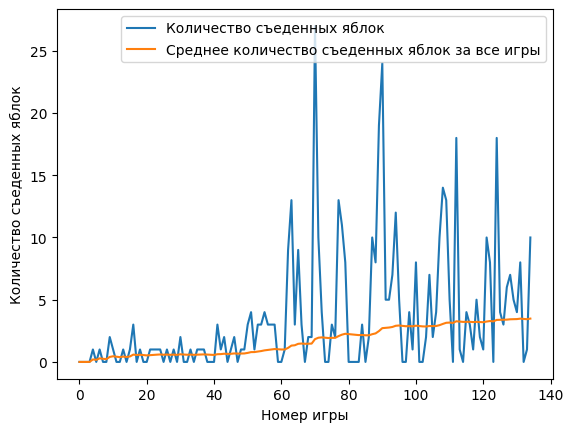

In [31]:
plt.plot(scoresHistory)
plt.ylabel('Количество съеденных яблок')
plt.xlabel('Номер игры')
plt.plot(meanScores)
plt.legend(["Количество съеденных яблок", "Среднее количество съеденных яблок за все игры"])